In [1]:
!pip install attacut
!pip install kaggle
!pip install pythainlp
!pip install pytorch-lightning
!pip install datasets
!pip install torch
!pip install wandb

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.2/87.2 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 36.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 473.8/473.8 kB 25.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.5 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 31.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.7 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 83.0 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
import numpy as np # linear algebra
import pandas as pd
import pandas
import sklearn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import textwrap
import attacut
import pythainlp
import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import WandbLogger

from torch.utils.data import Dataset
from IPython.display import display
from collections import defaultdict
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm

In [3]:
import os
import wandb

# Disable tokenizers parallelism warning
os.environ["TOKENIZERS_PARALLELISM"] = "false"

# Login to wandb
wandb.login(key="65e03aafcd9e07b23dd4cf63309c4f2c353f1623")

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: crimsonf09 (crimsonf09-chulalongkorn-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [4]:
run = wandb.init(
    # entity="Ella",
    # # Set the wandb project where this run will be logged.
    project="Ella",
    # Track hyperparameters and run metadata.
    config={
        "learning_rate": 0.02,
        "architecture": "BERT",
        "dataset": "CIFAR-100",
        "epochs": 10,
    },
)

In [5]:
type = ['Paper Work',
'Summary',
'Paraphrase',
'Simulation Role Play as a Character',
'Reasoning',
'Trending',
'Caption Generation',
'General',
'Marketing Planning']

In [6]:
def cleanData(pathCSV,filename):    
    data = []
    with open(pathCSV, "r", encoding="utf-8") as file:
        get_cols = False
        current_type = None
        current_context = None
        current_sentence = ""
    
        for line in file:
            line = line.strip()
            if not get_cols:
                cols = line.split(",")
                get_cols = True
                continue
    
            parts = line.split(",", 2)  # split into 3 parts only
    
            if len(parts) == 3:
                # Save the previous sentence before starting a new row
                if current_type is not None:
                    data.append([current_type, current_context, current_sentence.strip()])
                current_type = parts[0]
                current_context = parts[1]
                current_sentence = parts[2]
            else:
                # Continuation of sentence
                current_sentence += "\n" + line
    
        # Add the last row
        if current_type is not None:
            data.append([current_type, current_context, current_sentence.strip()])
    
    # Create DataFrame
    df = pd.DataFrame(data, columns=["type", "contextLevel", "sentence"])
    
    # Save as CSV
    df.to_csv('/kaggle/working/'+filename+'.csv', index=False)
    
    print("done " + filename)

In [7]:
cleanData('/kaggle/input/generated-data/generated_data.csv','cleaned_generated_data')
cleanData('/kaggle/input/generated-thai-dataset/generated_thai_data.csv','cleaned_generated_thai_data')

done cleaned_generated_data
done cleaned_generated_thai_data


In [8]:
# eng_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_data.csv")
# thai_generated_data = pd.read_csv("/kaggle/working/cleaned_generated_thai_data.csv")
# thai_hard_generated_data = pd.read_csv("/kaggle/input/generated-thai-hard-data-csv/generated_thai_hard_data.csv")
new_thai = pd.read_csv("/kaggle/input/new-thai-generated/generated_thai.csv", on_bad_lines="skip", encoding="utf-8")


In [9]:
import csv

filename = "/kaggle/input/new-thai-generated/generated_thai.csv"

with open(filename, "r", encoding="utf-8", errors="ignore") as f:
    reader = csv.reader(f)
    for i, row in enumerate(reader, start=1):
        try:
            _ = row  # try parsing the row
        except Exception as e:
            print(f"❌ Error on line {i}: {e}")
print('done')

done


In [10]:
print(new_thai.head())

               type difficulty  \
0  research_insight       easy   
1  research_insight       easy   
2  research_insight       easy   
3  research_insight       easy   
4  research_insight       easy   

                                            sentence  
0            ช่วยวิเคราะห์ข้อมูลยอดขายไตรมาสนี้หน่อย  
1           หาข้อมูล market share ของคู่แข่งให้หน่อย  
2  ต้องการ insight เกี่ยวกับพฤติกรรมลูกค้าในช่วง ...  
3  วิเคราะห์ trend การใช้ social media ของกลุ่มเป...  
4  ช่วยดู data customer satisfaction จากแบบสำรวจล...  


In [11]:
# print(eng_generated_data['sentence'].isnull().sum())

In [12]:
# print(thai_generated_data['type'].value_counts())
# print(eng_generated_data['type'].value_counts())
print(new_thai['type'].value_counts())

type
candidate_screening         164
research_insight            161
goal_breakdown              161
paraphrase                  161
strategy_planning           160
judgment_decision           160
creative_idea_generation    160
idea_validation             160
judgment_hr_decision        160
Name: count, dtype: int64


In [13]:
# thai_df = pd.DataFrame(thai_generated_data)
# thai_hard_df = pd.DataFrame(thai_hard_generated_data)
# eng_df = pd.DataFrame(eng_generated_data)
thai_df = pd.DataFrame(new_thai)

In [14]:
# type = ['Paper Work',
# 'Summary',
# 'Paraphrase',
# 'Simulation Role Play as a Character',
# 'Reasoning',
# 'Trending',
# 'Caption Generation',
# 'General',
# 'Marketing Planning']
type = [
    "research_insight",
    "strategy_planning",
    "goal_breakdown",
    "creative_idea_generation",
    "judgment_decision",
    "judgment_hr_decision",
    "idea_validation",
    "paraphrase",
    "candidate_screening"
]

type2ind={}
ind2type={}
ind = 0
for i in type:
    type2ind[i] = ind
    ind2type[ind] = i
    ind += 1
context_level = thai_df['difficulty'].unique()
print(context_level)
context2level = {}
level2context = {}
ind = 0
for i in context_level:
    context2level[i] = ind
    level2context[ind] = i
    ind+=1

['easy' 'medium' 'hard']


In [15]:
thai_df['type'] = thai_df['type'].map(type2ind)
thai_df['contextLevel'] = thai_df['difficulty'].map(context2level)
# thai_hard_df['type'] = thai_hard_df['type'].map(type2ind)
# thai_hard_df['contextLevel'] = thai_hard_df['contextLevel'].map(context2level)
# eng_df['type'] = eng_df['type'].map(type2ind)
# eng_df['contextLevel'] = eng_df['contextLevel'].map(context2level)

In [16]:
thai_df = thai_df.drop(columns=['difficulty'])


In [17]:
from sklearn.preprocessing import OneHotEncoder
import pandas as pd

# Example input
# thai_df['type'] = [0, 1, 2, 1, 0]

# 1. Initialize encoder
encoder = OneHotEncoder(sparse_output=False, dtype=int)  # updated param name: sparse_output

# 2. Fit and transform
one_hot_array = encoder.fit_transform(thai_df[['type']])  # Must be 2D

# 3. Get column names
columns = encoder.get_feature_names_out(['type'])  # e.g., ['type_0', 'type_1', ...]

# 4. Create one-hot DataFrame
one_hot_df = pd.DataFrame(one_hot_array, columns=columns, index=thai_df.index)

# 5. Join with original DataFrame
thai_df = pd.concat([thai_df, one_hot_df], axis=1)


In [18]:
label_cols = [col for col in thai_df.columns if col.startswith('type_')]

# Combine those columns into a list/array per row
thai_df['type_list'] = thai_df[label_cols].values.tolist()
print(thai_df['type_list'])

0       [1, 0, 0, 0, 0, 0, 0, 0, 0]
1       [1, 0, 0, 0, 0, 0, 0, 0, 0]
2       [1, 0, 0, 0, 0, 0, 0, 0, 0]
3       [1, 0, 0, 0, 0, 0, 0, 0, 0]
4       [1, 0, 0, 0, 0, 0, 0, 0, 0]
                   ...             
1442    [0, 0, 0, 0, 0, 0, 0, 0, 1]
1443    [0, 0, 0, 0, 0, 0, 0, 0, 1]
1444    [0, 0, 0, 0, 0, 0, 0, 0, 1]
1445    [0, 0, 0, 0, 0, 0, 0, 0, 1]
1446    [0, 0, 0, 0, 0, 0, 0, 0, 1]
Name: type_list, Length: 1447, dtype: object


In [19]:

def train_val_test_split(df):
    # First split: Train 60%, Temp 40%
    train_df, temp_df = train_test_split(
        df,
        train_size=0.6,
        random_state=99,
        stratify=df[['type', 'contextLevel']]
    )

    # Second split: Val 20%, Test 20% (half of temp)
    val_df, test_df = train_test_split(
        temp_df,
        train_size=0.5,
        random_state=99,
        stratify=temp_df[['type', 'contextLevel']]
    )

    return train_df.reset_index(drop=True), val_df.reset_index(drop=True), test_df.reset_index(drop=True)

In [20]:
thai_train_df,thai_val_df,thai_test_df = train_val_test_split(thai_df)
# eng_train_df,eng_val_df,eng_test_df = train_val_test_split(eng_df)
# thai_hard_train_df,thai_hard_val_df,thai_hard_test_df = train_val_test_split(thai_hard_df)
# train_df = pd.concat([thai_train_df,eng_train_df,thai_hard_train_df])
# val_df = pd.concat([thai_val_df,eng_val_df,thai_hard_val_df])
# test_df = pd.concat([thai_test_df,eng_test_df,thai_hard_test_df])
# test = thai_hard_test_df
train_df = thai_train_df
val_df = thai_val_df
test_df = thai_test_df

In [21]:
# from difflib import SequenceMatcher

# def is_similar(a, b, threshold=0.95):
#     return SequenceMatcher(None, a, b).ratio() > threshold

# suspicious = []
# for val_sentence in val_df['sentence']:
#     for train_sentence in train_df['sentence']:
#         if is_similar(val_sentence, train_sentence):
#             suspicious.append((val_sentence, train_sentence))
#             break  # Stop early once one match is found

# print(f"Found {len(suspicious)} highly similar val samples in train set")

In [22]:
train_df['type'].value_counts()

type
8    98
0    97
2    97
3    96
7    96
5    96
6    96
1    96
4    96
Name: count, dtype: int64

In [23]:
print(torch.cuda.is_available())

True


In [24]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

checkpoint = "clicknext/phayathaibert"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

def tokenizer_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True
    )
    encoded['labels'] = dataset['type_list']
    return encoded
train_dataset = Dataset.from_pandas(train_df[['type_list','sentence']])
eval_dataset = Dataset.from_pandas(val_df[['type_list','sentence']])

print(train_dataset[0])

# tokenize
tokenized_train_dataset = train_dataset.map(tokenizer_dataset,batched=True)
tokenized_eval_dataset = eval_dataset.map(tokenizer_dataset,batched=True)

tokenized_train_dataset.set_format('torch')
tokenized_eval_dataset.set_format('torch')
# # dataloader
train_loader = DataLoader(tokenized_train_dataset,batch_size=64, shuffle=True)
eval_loader = DataLoader(tokenized_eval_dataset,batch_size=64, shuffle=False)

# train_loader = DataLoader(tokenized_train_dataset,batch_size=128, shuffle=True)
# eval_loader = DataLoader(tokenized_eval_dataset,batch_size=128, shuffle=False)

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/5.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.4M [00:00<?, ?B/s]

added_tokens.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/364 [00:00<?, ?B/s]

{'type_list': [0, 0, 0, 1, 0, 0, 0, 0, 0], 'sentence': 'คิดไอเดียสร้างสรรค์สำหรับการปรับปรุง supply chain และลดต้นทุน'}


Map:   0%|          | 0/868 [00:00<?, ? examples/s]

Map:   0%|          | 0/289 [00:00<?, ? examples/s]

In [25]:
class HuggingFaceDataset(torch.utils.data.Dataset):
    def __init__(self,hf_dataset):
        self.dataset = hf_dataset
    def __len__(self):
        return len(self.dataset)
    def __getitem__(self,idx):
        item = self.dataset[idx]
        input_ids = item['input_ids'].clone().detach().long()
        attention_mask = item['attention_mask'].clone().detach().long()
        labels = item['labels'].clone().detach().long()
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "labels": labels,
        }

In [26]:
train_dataset = HuggingFaceDataset(tokenized_train_dataset)
eval_dataset = HuggingFaceDataset(tokenized_eval_dataset)

# train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
# val_loader = DataLoader(eval_dataset, batch_size=32, shuffle=False)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(eval_dataset, batch_size=64, shuffle=False)

In [27]:
train_dataset.__getitem__(1)

{'input_ids': tensor([     5,     10,      3,  75208,  31176,  26844, 201582,  30120, 172916,
         125115,  28074, 189531, 106912,    110,  50108,    919,  65412, 157895,
             14,  32761,  25299, 138547,  28309,     14,  35277,  54992,     14,
          62659,  39330, 163626,   4249,     14,  26523,  68928, 209800,     14,
          25083,  38081,  45790,  25460,  50295,  62530,  21280,    110,     14,
         159311, 109831,     14,  56345,  48177,  13520,     14,  25083,  33696,
          25326,   3979,   3769,  58452,  25055,  35530,  97534,      6,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1

In [28]:
import torch
import torch.nn.functional as F
import pytorch_lightning as pl
from transformers import AutoModelForSequenceClassification
from sklearn.metrics import f1_score

class BertClassifier(pl.LightningModule):
    def __init__(self, model_name: str, num_labels: int = 9, learning_rate: float = 2e-5):
        super().__init__()
        self.save_hyperparameters()
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model_name,
            num_labels=num_labels,
            problem_type="multi_label_classification"  # optional but recommended
        )

        # Accumulators for validation and test
        self.val_preds, self.val_labels = [], []
        self.test_preds, self.test_labels = [], []

    def forward(self, input_ids, attention_mask, labels=None):
        return self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            labels=labels
        )

    def training_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits  # shape (batch_size, num_labels)
        labels = batch['labels'].float()  # ensure float for BCEWithLogitsLoss
        loss = F.binary_cross_entropy_with_logits(logits, labels)
        self.log("train_loss", loss, prog_bar=True)
        return loss

    def validation_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        labels = batch['labels'].cpu().numpy()

        probs = torch.sigmoid(logits).cpu().numpy()

        self.val_preds.append(probs)   # keep float probabilities
        self.val_labels.append(labels)

        loss = F.binary_cross_entropy_with_logits(logits, batch['labels'].float())
        self.log("val_loss", loss, prog_bar=True)
        return loss

    def on_validation_epoch_end(self):
        import numpy as np
        from sklearn.metrics import average_precision_score

        val_preds = np.vstack(self.val_preds)
        val_labels = np.vstack(self.val_labels)

        # Calculate average precision (AP) score for multi-label
        ap = average_precision_score(val_labels, val_preds, average="micro")
        self.log("val_average_precision", ap, prog_bar=True)
        print(f"Validation Average Precision (micro): {ap:.4f}")

        self.val_preds.clear()
        self.val_labels.clear()

    def test_step(self, batch, batch_idx):
        outputs = self.model(
            input_ids=batch['input_ids'],
            attention_mask=batch['attention_mask']
        )
        logits = outputs.logits
        labels = batch['labels'].cpu().numpy()

        probs = torch.sigmoid(logits)
        preds = (probs > 0.5).int().cpu().numpy()
        self.test_preds.append(preds)
        # probs = torch.sigmoid(logits).cpu().numpy()
        # self.test_preds.append(probs)

        self.test_labels.append(labels)

        loss = F.binary_cross_entropy_with_logits(logits, batch['labels'].float())
        return loss

    def on_test_epoch_end(self):
        import numpy as np
        test_preds = np.vstack(self.test_preds)
        test_labels = np.vstack(self.test_labels)

        f1 = f1_score(test_labels, test_preds, average="micro", zero_division=0)
        self.log("test_f1", f1)
        print(f"\n🔍 Test F1 Score (micro): {f1:.4f}")

        self.test_preds.clear()
        self.test_labels.clear()

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=self.hparams.learning_rate)


In [29]:
model = BertClassifier(model_name=checkpoint, num_labels=9) 

epoch = 4
wandb_logger = WandbLogger(
    project="bert-multiclass",     # Your project name in wandb
    name="bert-run-001",           # Optional run name
    log_model="all"                # Optionally save model checkpoints to wandb
)
trainer = pl.Trainer(
    max_epochs = epoch,
    accelerator = "gpu" if torch.cuda.is_available() else "cpu",
    devices = 1,
    # precision=16,   # optional
    logger=wandb_logger
)

trainer.fit(model, train_loader, val_loader)

config.json:   0%|          | 0.00/642 [00:00<?, ?B/s]

2025-07-22 10:04:28.140044: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1753178668.357479      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1753178668.418154      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


model.safetensors:   0%|          | 0.00/1.11G [00:00<?, ?B/s]

Some weights of CamembertForSequenceClassification were not initialized from the model checkpoint at clicknext/phayathaibert and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loggers/wandb.py:397: There is a wandb run already in progress and newly created instances of `WandbLogger` will reuse this run. If this is not desired, call `wandb.finish()` before instantiating `WandbLogger`.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.


Validation Average Precision (micro): 0.1137


/usr/local/lib/python3.11/dist-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (14) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation Average Precision (micro): 0.2013


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Average Precision (micro): 0.4483


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Average Precision (micro): 0.6619


Validation: |          | 0/? [00:00<?, ?it/s]

Validation Average Precision (micro): 0.8671


In [30]:
import torch
import numpy as np
import pandas as pd
from torch.utils.data import DataLoader
from datasets import Dataset
from transformers import AutoTokenizer

# Assuming your model and tokenizer are already defined as follows:
model_name = "clicknext/phayathaibert"  # Change this to your model's name if necessary
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Initialize device and model (your model already has this part)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

def tokenize_test_dataset(dataset):
    encoded = tokenizer(
        dataset['sentence'],
        padding='max_length',
        max_length=256,#128
        truncation=True,
    )
    return encoded

# Assuming `test_df` is your test data frame containing 'comment' column.
test_dataset = Dataset.from_pandas(test_df)

# Apply the tokenizer to the dataset
test_dataset = test_dataset.map(tokenize_test_dataset, batched=True)

# Set the format to be suitable for PyTorch (with input_ids and attention_mask)
test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask"])

# Prepare DataLoader for the test set
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Set the model to evaluation mode
model.eval()

predictions = []

# Run inference
with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        
        # Forward pass through the model
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        
        logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)  # Apply softmax for multi-class classification
        
        # Get the predicted class (index of highest probability)
        preds = torch.argmax(probs, dim=-1)
        print(preds)
        predictions.append(preds.cpu().numpy())  # Store predictions in CPU memory

# Concatenate all predictions into a single array
predicted_labels = np.concatenate(predictions, axis=0)
print(probs.cpu().numpy())  # This prints the float scores for each class
# Create a DataFrame to store predictions with a single column 'predicted_label'
preds_df = pd.DataFrame(predicted_labels, columns=["predicted_label"])

# Print out the predictions for the first 20 samples
for text, real_label,label in zip(test_df["sentence"],test_df['type'], predicted_labels):
    if (real_label != label):
        print(f"Text: {text}")
        print(f"True Label: {ind2type[real_label]}")
        print(f"Predicted Label: {ind2type[label]}")
        print("-" * 50)
        print("")


Map:   0%|          | 0/290 [00:00<?, ? examples/s]

tensor([7, 2, 0, 8, 5, 6, 7, 6, 3, 8, 0, 7, 2, 2, 7, 0, 0, 5, 4, 5, 1, 0, 7, 1,
        2, 3, 5, 5, 8, 3, 4, 2, 3, 6, 7, 6, 5, 3, 3, 2, 7, 4, 7, 1, 3, 7, 8, 7,
        5, 3, 1, 2, 1, 6, 1, 0, 8, 8, 5, 3, 2, 8, 4, 3], device='cuda:0')
tensor([4, 4, 7, 0, 4, 0, 2, 0, 7, 4, 3, 1, 0, 0, 2, 7, 0, 7, 8, 1, 8, 3, 1, 6,
        0, 5, 1, 2, 2, 7, 3, 0, 3, 3, 3, 4, 4, 2, 7, 4, 1, 7, 2, 4, 4, 8, 1, 6,
        0, 7, 8, 4, 5, 5, 3, 7, 8, 5, 4, 5, 4, 5, 1, 2], device='cuda:0')
tensor([7, 4, 5, 8, 5, 5, 3, 4, 6, 7, 8, 7, 0, 0, 3, 7, 7, 1, 5, 6, 8, 4, 1, 1,
        8, 5, 4, 3, 0, 3, 7, 0, 0, 4, 4, 0, 1, 0, 3, 0, 1, 7, 1, 8, 8, 6, 1, 3,
        8, 8, 3, 0, 6, 2, 0, 0, 8, 0, 5, 0, 0, 7, 0, 1], device='cuda:0')
tensor([0, 3, 0, 4, 3, 5, 7, 5, 1, 7, 8, 5, 0, 8, 8, 1, 7, 4, 3, 3, 2, 3, 8, 3,
        6, 1, 4, 0, 1, 3, 4, 0, 2, 8, 1, 1, 2, 8, 8, 3, 0, 2, 0, 7, 5, 8, 8, 1,
        3, 5, 3, 8, 6, 8, 5, 0, 7, 1, 3, 3, 3, 5, 0, 6], device='cuda:0')
tensor([6, 7, 6, 4, 8, 3, 1, 4, 5, 5, 2, 1, 8, 5, 2, 8, 2, 5, 1,

In [31]:
predicted_labels

array([7, 2, 0, 8, 5, 6, 7, 6, 3, 8, 0, 7, 2, 2, 7, 0, 0, 5, 4, 5, 1, 0,
       7, 1, 2, 3, 5, 5, 8, 3, 4, 2, 3, 6, 7, 6, 5, 3, 3, 2, 7, 4, 7, 1,
       3, 7, 8, 7, 5, 3, 1, 2, 1, 6, 1, 0, 8, 8, 5, 3, 2, 8, 4, 3, 4, 4,
       7, 0, 4, 0, 2, 0, 7, 4, 3, 1, 0, 0, 2, 7, 0, 7, 8, 1, 8, 3, 1, 6,
       0, 5, 1, 2, 2, 7, 3, 0, 3, 3, 3, 4, 4, 2, 7, 4, 1, 7, 2, 4, 4, 8,
       1, 6, 0, 7, 8, 4, 5, 5, 3, 7, 8, 5, 4, 5, 4, 5, 1, 2, 7, 4, 5, 8,
       5, 5, 3, 4, 6, 7, 8, 7, 0, 0, 3, 7, 7, 1, 5, 6, 8, 4, 1, 1, 8, 5,
       4, 3, 0, 3, 7, 0, 0, 4, 4, 0, 1, 0, 3, 0, 1, 7, 1, 8, 8, 6, 1, 3,
       8, 8, 3, 0, 6, 2, 0, 0, 8, 0, 5, 0, 0, 7, 0, 1, 0, 3, 0, 4, 3, 5,
       7, 5, 1, 7, 8, 5, 0, 8, 8, 1, 7, 4, 3, 3, 2, 3, 8, 3, 6, 1, 4, 0,
       1, 3, 4, 0, 2, 8, 1, 1, 2, 8, 8, 3, 0, 2, 0, 7, 5, 8, 8, 1, 3, 5,
       3, 8, 6, 8, 5, 0, 7, 1, 3, 3, 3, 5, 0, 6, 6, 7, 6, 4, 8, 3, 1, 4,
       5, 5, 2, 1, 8, 5, 2, 8, 2, 5, 1, 3, 0, 2, 3, 7, 2, 1, 7, 6, 2, 5,
       5, 5, 4, 8])

Accuracy: 0.8483
F1 Scores:
  Micro:    0.8483
  Macro:    0.8420
  Weighted: 0.8428

Classification Report:
              precision    recall  f1-score   support

           0       0.78      0.97      0.86        32
           1       0.85      0.88      0.86        32
           2       1.00      0.81      0.90        32
           3       0.80      1.00      0.89        32
           4       0.76      0.69      0.72        32
           5       0.71      0.75      0.73        32
           6       1.00      0.53      0.69        32
           7       0.94      1.00      0.97        33
           8       0.92      1.00      0.96        33

    accuracy                           0.85       290
   macro avg       0.86      0.85      0.84       290
weighted avg       0.86      0.85      0.84       290



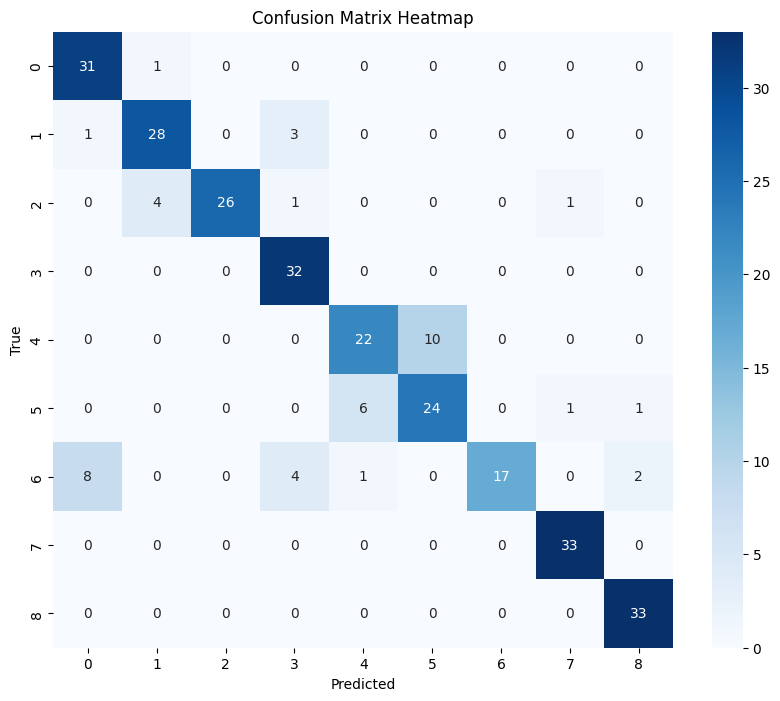

In [32]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import seaborn as sns
import matplotlib.pyplot as plt

# Example: Assuming these are already defined
# test_df = pd.DataFrame({'type': [...your true labels...]})
# predicted_labels = [...your predicted labels...]

# Convert to NumPy arrays (if needed)
true_labels = np.array(test_df['type'])
preds = np.array(predicted_labels)

# Accuracy
acc = accuracy_score(true_labels, preds)
print(f"Accuracy: {acc:.4f}")

# F1 Score (macro, micro, weighted)
print("F1 Scores:")
print(f"  Micro:    {f1_score(true_labels, preds, average='micro'):.4f}")
print(f"  Macro:    {f1_score(true_labels, preds, average='macro'):.4f}")
print(f"  Weighted: {f1_score(true_labels, preds, average='weighted'):.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(true_labels, preds))

# Confusion Matrix
cm = confusion_matrix(true_labels, preds)
labels = sorted(np.unique(np.concatenate([true_labels, preds])))

# Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix Heatmap')
plt.show()

In [33]:
type2ind

{'research_insight': 0,
 'strategy_planning': 1,
 'goal_breakdown': 2,
 'creative_idea_generation': 3,
 'judgment_decision': 4,
 'judgment_hr_decision': 5,
 'idea_validation': 6,
 'paraphrase': 7,
 'candidate_screening': 8}

In [34]:
trainer.save_checkpoint("bert_multiclass_new.ckpt")

In [35]:
# text = "give me the 3 month online plan for NIKE"
text = "As a marketing planner what is the best method to understand customer"
text = "Is this the best word to engage maximum user view"
text = "Sum up thai politic news today"
text = "Write this email as polite as possible good morning mr.CCC"
text = "What is the best method to understand "
# Tokenize
inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
inputs = {k: v.to(device) for k, v in inputs.items()}

# Run model
model.eval()
with torch.no_grad():
    outputs = model(**inputs)
    probs = torch.softmax(outputs.logits, dim=-1)
    pred = torch.argmax(probs, dim=-1).item()

# Map prediction to label
print("Predicted label:", ind2type[pred])


Predicted label: paraphrase


In [36]:
regenerated_sentences = {
    "Paper Work": "Buried under mountains of redundant forms, I had a eureka moment — what if bureaucracy became our next viral caption trend?",
    
    "Summary": "I'll lawyer this beast of a legal doc into a few punchy bullet points, powered by cold logic and a strong cup of coffee.",
    
    "Paraphrase": "Translate that techy jargon into robo-speak — imagine a toaster explaining its user manual with flair and existential dread.",
    
    "Simulation Role Play as a Character": "In character mode, I accidentally unearthed a meme-worthy origin story — the kind that breaks the fourth wall with style.",
    
    "Reasoning": "Solving the marketing puzzle with deductive finesse — the more niche our audience, the sharper our conversion rate.",
    
    "Trending": "This trend is so flaming hot, it practically demands a sarcastic remix that'll set the internet on fire.",
    
    "Caption Generation": "Let’s turn the video’s summary into a scroll-stopping caption that’s snappy, witty, and dangerously shareable.",
    
    "General": "When you're drowning in paperwork, just logic-puzzle your way out — bonus points if you do it with sarcasm.",
    
    "Marketing Planning": "Our secret sauce? Tapping into what’s trending and spinning it into content gold — like forecasting memes with a crystal ball."
}
# Loop through regenerated sentences
for ans, text in regenerated_sentences.items():
    print(f"📝 Text: {text}")

    # Tokenize
    inputs = tokenizer(text, return_tensors="pt", padding="max_length", truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}

    # Run model
    model.eval()
    with torch.no_grad():
        outputs = model(**inputs)
        probs = torch.softmax(outputs.logits, dim=-1)
        pred = torch.argmax(probs, dim=-1).item()

    # Print predicted label and the correct answer tag
    print(f"🔍 Predicted label: {ind2type[pred]}")
    print(f"✅ Expected category: {ans}")
    print("-" * 60)


📝 Text: Buried under mountains of redundant forms, I had a eureka moment — what if bureaucracy became our next viral caption trend?
🔍 Predicted label: paraphrase
✅ Expected category: Paper Work
------------------------------------------------------------
📝 Text: I'll lawyer this beast of a legal doc into a few punchy bullet points, powered by cold logic and a strong cup of coffee.
🔍 Predicted label: paraphrase
✅ Expected category: Summary
------------------------------------------------------------
📝 Text: Translate that techy jargon into robo-speak — imagine a toaster explaining its user manual with flair and existential dread.
🔍 Predicted label: paraphrase
✅ Expected category: Paraphrase
------------------------------------------------------------
📝 Text: In character mode, I accidentally unearthed a meme-worthy origin story — the kind that breaks the fourth wall with style.
🔍 Predicted label: paraphrase
✅ Expected category: Simulation Role Play as a Character
-----------------------